In [95]:
import os
import re
import sys

import pandas
import yaml

################################################################################
# Boilerplate
################################################################################

# ANSI SGR control codes for text formatting
class Text:
    DEFAULT = "\x1b[0m"
    BOLD = "\x1b[1m"
    BOLD_OFF = "\x1b[22m"
    UNDERLINE = "\x1b[4m"
    UNDERLINE_OFF = "\x1b[24m"
    DEFAULT_COLOR = "\x1b[39m"
    DEFAULT_BG_COLOR = "\x1b[49m"
    RED = "\x1b[31m"
    YELLOW = "\x1b[33m"
    GREEN = "\x1b[32m"
    CYAN = "\x1b[36m"
    BLUE = "\x1b[34m"
    MAGENTA = "\x1b[35m"
    BLACK = "\x1b[30m"
    WHITE = "\x1b[37m"
    BG_RED = "\x1b[41m"
    BG_YELLOW = "\x1b[43m"
    BG_GREEN = "\x1b[42m"
    BG_CYAN = "\x1b[46m"
    BG_BLUE = "\x1b[44m"
    BG_MAGENTA = "\x1b[45m"
    BG_BLACK = "\x1b[40m"
    BG_WHITE = "\x1b[47m"


def warn(mesg: str) -> None:
    sys.stderr.write(f'{Text.YELLOW}{mesg}\n{Text.DEFAULT}')


def error(mesg: str, err_code: int = 1) -> None:
    sys.stderr.write(f'{Text.RED}{mesg}\n{Text.DEFAULT}')
    sys.exit(err_code)


def import_yaml(file_path: str) -> dict[any, any]:
    with open(file_path, 'r', encoding='UTF-8') as file:
        data = yaml.safe_load(file)
    return data


def get_results_files(run_dir: str) -> list[str]:
    """
    Get list of results files from run.

    If a particular workload has multiple results files, pick newest based on
    filename's date.
    """
    results_files = []
    if not os.path.isdir(run_dir):
        warn(f'Invalid run directory: {run_dir}')
        return results_files
    if not os.path.isdir(os.path.join(run_dir, 'results')):
        warn(f'"results" directory missing in run: {run_dir}')
        return results_files
    # Within the results directory of a run, there can be several benchmarks
    for benchmark in os.listdir(os.path.join(run_dir, 'results')):
        if not os.path.isdir(os.path.join(run_dir, 'results', benchmark)):
            continue
        # Sort files by newest first
        files_sorted = sorted(
            os.listdir(os.path.join(run_dir, 'results', benchmark)),
            # Sorting by modified time will not work if files are copied
            # locally in arbitrary order
            #key=lambda ff: os.path.getmtime(os.path.join(run_dir, "results", benchmark, ff)),
            reverse=True)
        for file in files_sorted:
            if not os.path.isfile(os.path.join(run_dir, 'results', benchmark, file)):
                continue
            if not re.search('^vllm.+\.json$', file):
                # Skip files that do not match result data filename
                continue
            results_files.append(os.path.join(run_dir, 'results', benchmark, file))
            break
    return results_files


def get_workload_profile(run_dir: str) -> dict[str, any]:
    """Get workload profile file from run."""
    if not os.path.isdir(run_dir):
        error(f'Invalid run directory: {run_dir}')
    if not os.path.isdir(os.path.join(run_dir, 'workload')):
        error(f'"workload" directory missing in run: {run_dir}')
    if not os.path.isdir(os.path.join(run_dir, 'workload', 'profiles')):
        error(f'"workload/profiles" directory missing in run: {run_dir}')
    # Get the workload file (there should be only one, and we will assume this)
    for file in os.listdir(os.path.join(run_dir, 'workload', 'profiles')):
        if os.path.isdir(os.path.join(run_dir, 'workload', 'profiles', file)):
            continue
        if not re.search('.+\.yaml$', file):
            # Skip files that do not match result data filename
            continue
        return import_yaml(os.path.join(run_dir, 'workload', 'profiles', file))


def get_envar(run_dir: str, envar: str) -> str:
    """Get value of environment variable in environment/variables file of run."""
    if not os.path.isdir(run_dir):
        error(f'Invalid run directory: {run_dir}')
    if not os.path.isdir(os.path.join(run_dir, "environment")):
        error(f'"environment" directory missing in run: {run_dir}')
    if not os.path.isfile(os.path.join(run_dir, "environment", "variables")):
        error(f'"variables" file missing in run: {os.path.join(run_dir, "environment")}')
    with open(os.path.join(run_dir, "environment", "variables"), "r", encoding="UTF-8") as file:
        for line in file:
            if envar in line:
                model = line.rsplit('=', 1)[-1].strip()
                if not model:
                    error(f'{envar} not defined: {run_dir}')
                return model
        error(f'{envar} missing from environment/variables: {run_dir}')

################################################################################
# Import data
################################################################################

# This is the directory containing run directories to import
source_dir = "./"

if not os.path.isdir(source_dir):
    sys.stderr.write(f'{Text.RED}Invalid path: {source_dir}\n{Text.DEFAULT}')
    sys.exit(1)

# Make a list of experimental directories
run_dirs = []
for file in os.listdir(source_dir):
    if not os.path.isdir(file):
        # Skip files that are not directories
        continue
    if not re.search('.+\_\_[0-9]+P-TP[0-9]+\_[0-9]+D-TP[0-9]+$', file):
        # Skip directories that do not match a swept run pattern
        continue
    run_dirs.append(file)

if not run_dirs:
    sys.stderr.write(f'{Text.RED}No run directories found in source directory: {source_dir}\n{Text.DEFAULT}')
    sys.exit(1)

run_dirs.sort()

# Set of configurations we have data from, in the format (p_tp, p_rep, d_tp, d_rep)
configs = set([])

# Create DataFrame for benchmark run results
runs = pandas.DataFrame(columns=[
    'Name',
    'Model',
    'GPU',
    'P_TP',
    'P_Replicas',
    'D_TP',
    'D_Replicas',
    'Concurrency',
    'ISL',
    'OSL',
    'Request_Throughput',
    'Output_Throughput',
    'Total_Token_Throughput',
    'Total_Input_Tokens',
    'Total_Output_Tokens',
    'Completed',
    'Mean_TTFT',
    'Std_TTFT',
    'Mean_TPOT',
    'Std_TPOT',
    'Mean_ITL',
    'Std_ITL',
    'Mean_E2E',
    'Std_E2E',
])

# Import data and populate DataFrame
for run in run_dirs:
    results_files = get_results_files(os.path.join(source_dir, run))
    model = get_envar(os.path.join(source_dir, run), 'LLMDBENCH_DEPLOY_MODEL_LIST')
    gpu = get_envar(os.path.join(source_dir, run), 'LLMDBENCH_VLLM_COMMON_AFFINITY').rsplit(':', 1)[-1]
    name, config_str = run.rsplit('__', 1)
    p_rep = int(config_str.split('P-TP', 1)[0])
    p_tp = int(config_str.split('P-TP', 1)[1].split('_', 1)[0])
    d_rep = int(config_str.rsplit('_', 1)[1].split('D-TP', 1)[0])
    d_tp = int(config_str.split('D-TP', 1)[1])
    configs.add((p_tp, p_rep, d_tp, d_rep))
    workload_profile = get_workload_profile(run)
    for rf in results_files:
        result_data = import_yaml(rf)
        runs.loc[len(runs)] = {
            'Name': name,
            'Model': model,
            'GPU': gpu,
            'P_TP': p_tp,
            'P_Replicas': p_rep,
            'D_TP': d_tp,
            'D_Replicas': d_rep,
            'Concurrency': result_data['max_concurrency'],
            'ISL': workload_profile['random-input-len'],
            'OSL': workload_profile['random-output-len'],
            'Request_Throughput': result_data['request_throughput'],
            'Output_Throughput': result_data['output_throughput'],
            'Total_Token_Throughput': result_data['total_token_throughput'],
            'Total_Input_Tokens': result_data['total_input_tokens'],
            'Total_Output_Tokens': result_data['total_output_tokens'],
            'Completed': result_data['completed'],
            'Mean_TTFT': result_data['mean_ttft_ms'],
            'Std_TTFT': result_data['std_ttft_ms'],
            'Mean_TPOT': result_data['mean_tpot_ms'],
            'Std_TPOT': result_data['std_tpot_ms'],
            'Mean_ITL': result_data['mean_itl_ms'],
            'Std_ITL': result_data['std_itl_ms'],
            'Mean_E2E': result_data['mean_e2el_ms'],
            'Std_E2E': result_data['std_e2el_ms'],
        }

# Preview data
runs

,Name,Model,GPU,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,ISL,OSL,...,Total_Output_Tokens,Completed,Mean_TTFT,Std_TTFT,Mean_TPOT,Std_TPOT,Mean_ITL,Std_ITL,Mean_E2E,Std_E2E
0,benchmark_run_pd,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,1,1,4,1,1,10000,1000,...,20000,20,4885.319184,1104.277838,3.889075,0.030756,3.891608,0.526518,8770.505423,1106.928396
1,benchmark_run_pd,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,1,1,4,1,1024,10000,1000,...,958000,958,324080.585457,63325.178454,6.644206,1.227813,6.645199,2.279221,330718.147322,63459.920253
2,benchmark_run_pd,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,1,1,4,1,512,10000,1000,...,241302,244,286181.709144,81107.309993,6.301467,0.959638,6.306015,2.282820,292429.548657,81221.817409
3,benchmark_run_pd,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,1,1,4,1,256,10000,1000,...,911968,916,332349.730960,55125.132442,6.606937,1.290135,6.604939,1.940842,338917.801322,55099.942355
4,benchmark_run_pd,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,1,1,4,1,32,10000,1000,...,640000,640,147346.632634,43034.832420,6.424908,1.222771,6.425742,1.758979,153765.115465,43140.334765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,benchmark_run_pd,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,4,1,8,5,1,10000,1000,...,20000,20,2628.937538,601.385057,3.681870,0.020937,3.682054,0.484616,6307.125624,606.532374
61,benchmark_run_pd,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,4,1,8,5,64,10000,1000,...,1280000,1280,156960.448827,54527.374539,11.277102,1.040101,11.279545,3.216013,168226.273501,54523.607263
62,benchmark_run_pd,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,4,1,8,5,8,10000,1000,...,160000,160,16570.359404,6210.828616,4.638935,0.270112,4.639631,0.857880,21204.654997,6164.859824
63,benchmark_run_pd,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,4,1,8,5,512,10000,1000,...,1811126,1812,383524.641577,57547.807305,20.809743,3.293464,20.814348,9.152814,404307.492239,58190.358754


In [96]:
runs.columns

Index(['Name', 'Model', 'GPU', 'P_TP', 'P_Replicas', 'D_TP', 'D_Replicas',
       'Concurrency', 'ISL', 'OSL', 'Request_Throughput', 'Output_Throughput',
       'Total_Token_Throughput', 'Total_Input_Tokens', 'Total_Output_Tokens',
       'Completed', 'Mean_TTFT', 'Std_TTFT', 'Mean_TPOT', 'Std_TPOT',
       'Mean_ITL', 'Std_ITL', 'Mean_E2E', 'Std_E2E'],
      dtype='object')

In [97]:
# Filters
isl = 10000
osl = 1000
model = 'Qwen/Qwen1.5-MoE-A2.7B-Chat'

# Filter on column values, then pick specific columns from dataset to analyze
runs_selected = runs[
    (runs['ISL'] == isl) &
    (runs['OSL'] == osl) &
    (runs['Model'] == model)][[
    'Model',
    'P_TP',
    'P_Replicas',
    'D_TP',
    'D_Replicas',
    'Concurrency',
    'ISL',
    'OSL',
    'Output_Throughput']].drop('Model', axis=1).drop('ISL', axis=1).drop('OSL', axis=1).sort_values(by='Output_Throughput')
# Add calculated columns
runs_selected['Num_GPUs'] = runs_selected['P_TP']*runs_selected['P_Replicas'] + runs_selected['D_TP']*runs_selected['D_Replicas']
runs_selected['Thpt_per_GPU'] = runs_selected['Output_Throughput']/runs_selected['Num_GPUs']
runs_selected['Thpt_per_User'] = runs_selected['Output_Throughput']/runs_selected['Concurrency']
# Preview
runs_selected

,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Throughput,Num_GPUs,Thpt_per_GPU,Thpt_per_User
25,1,1,8,5,1,111.139377,41,2.710717,111.139377
0,1,1,4,1,1,114.009905,5,22.801981,114.009905
17,1,1,8,2,1,118.579411,17,6.975259,118.579411
9,1,1,8,1,1,120.999930,9,13.444437,120.999930
45,2,1,8,2,1,157.795092,18,8.766394,157.795092
...,...,...,...,...,...,...,...,...,...
53,2,1,8,5,128,409.431782,42,9.748376,3.198686
51,2,1,8,5,8,412.588743,42,9.823542,51.573593
50,2,1,8,5,512,483.821236,42,11.519553,0.944963
18,1,1,8,2,512,569.098619,17,33.476389,1.111521


In [98]:
# See what configurations we have data on
# Format is (p_tp, p_rep, d_tp, d_rep)
configs

{(1, 1, 4, 1),
 (1, 1, 8, 1),
 (1, 1, 8, 2),
 (1, 1, 8, 5),
 (2, 1, 8, 1),
 (2, 1, 8, 2),
 (2, 1, 8, 5),
 (4, 1, 8, 5)}

,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Throughput,Num_GPUs,Thpt_per_GPU,Thpt_per_User
9,1,1,8,1,1,120.999930,9,13.444437,120.999930
15,1,1,8,1,8,194.901629,9,21.655737,24.362704
16,1,1,8,1,16,187.500020,9,20.833336,11.718751
12,1,1,8,1,32,187.295607,9,20.810623,5.852988
13,1,1,8,1,64,187.679925,9,20.853325,2.932499
14,1,1,8,1,128,189.640133,9,21.071126,1.481564
11,1,1,8,1,256,192.957185,9,21.439687,0.753739
10,1,1,8,1,512,189.770508,9,21.085612,0.370646


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Throughput,Num_GPUs,Thpt_per_GPU,Thpt_per_User
45,2,1,8,2,1,157.795092,18,8.766394,157.795092
44,2,1,8,2,8,386.611888,18,21.478438,48.326486
42,2,1,8,2,16,384.058663,18,21.336592,24.003666
46,2,1,8,2,32,390.888053,18,21.716003,12.215252
43,2,1,8,2,64,378.840052,18,21.046670,5.919376
41,2,1,8,2,128,390.757719,18,21.708762,3.052795
47,2,1,8,2,256,391.433854,18,21.746325,1.529038
48,2,1,8,2,512,346.253089,18,19.236283,0.676276


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Throughput,Num_GPUs,Thpt_per_GPU,Thpt_per_User
49,2,1,8,5,1,159.342335,42,3.793865,159.342335
51,2,1,8,5,8,412.588743,42,9.823542,51.573593
54,2,1,8,5,16,395.737499,42,9.422321,24.733594
52,2,1,8,5,32,396.836900,42,9.448498,12.401153
55,2,1,8,5,64,406.746931,42,9.684451,6.355421
53,2,1,8,5,128,409.431782,42,9.748376,3.198686
56,2,1,8,5,256,397.432807,42,9.462686,1.552472
50,2,1,8,5,512,483.821236,42,11.519553,0.944963


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Throughput,Num_GPUs,Thpt_per_GPU,Thpt_per_User
60,4,1,8,5,1,158.535763,44,3.603086,158.535763
62,4,1,8,5,8,373.431864,44,8.487088,46.678983
64,4,1,8,5,16,371.738391,44,8.448600,23.233649
59,4,1,8,5,32,375.376950,44,8.531294,11.730530
61,4,1,8,5,64,375.739170,44,8.539527,5.870925
58,4,1,8,5,128,378.332434,44,8.598464,2.955722
57,4,1,8,5,256,370.994671,44,8.431697,1.449198
63,4,1,8,5,512,376.771674,44,8.562993,0.735882


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Throughput,Num_GPUs,Thpt_per_GPU,Thpt_per_User
36,2,1,8,1,1,158.535763,10,15.853576,158.535763
38,2,1,8,1,8,373.431864,10,37.343186,46.678983
40,2,1,8,1,16,371.738391,10,37.173839,23.233649
35,2,1,8,1,32,375.376950,10,37.537695,11.730530
37,2,1,8,1,64,375.739170,10,37.573917,5.870925
34,2,1,8,1,128,378.332434,10,37.833243,2.955722
33,2,1,8,1,256,370.994671,10,37.099467,1.449198
39,2,1,8,1,512,376.771674,10,37.677167,0.735882


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Throughput,Num_GPUs,Thpt_per_GPU,Thpt_per_User
0,1,1,4,1,1,114.009905,5,22.801981,114.009905
7,1,1,4,1,8,195.988959,5,39.197792,24.498620
8,1,1,4,1,16,202.153252,5,40.430650,12.634578
4,1,1,4,1,32,205.002011,5,41.000402,6.406313
5,1,1,4,1,64,199.988322,5,39.997664,3.124818
6,1,1,4,1,128,198.838961,5,39.767792,1.553429
3,1,1,4,1,256,198.271191,5,39.654238,0.774497
2,1,1,4,1,512,197.079376,5,39.415875,0.384921
1,1,1,4,1,1024,198.305029,5,39.661006,0.193657


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Throughput,Num_GPUs,Thpt_per_GPU,Thpt_per_User
25,1,1,8,5,1,111.139377,41,2.710717,111.139377
31,1,1,8,5,8,183.257986,41,4.469707,22.907248
32,1,1,8,5,16,185.075064,41,4.514026,11.567192
28,1,1,8,5,32,191.641792,41,4.674190,5.988806
29,1,1,8,5,64,191.397158,41,4.668223,2.990581
30,1,1,8,5,128,195.751361,41,4.774423,1.529308
27,1,1,8,5,256,193.620034,41,4.722440,0.756328
26,1,1,8,5,512,1406.036250,41,34.293567,2.746165


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Throughput,Num_GPUs,Thpt_per_GPU,Thpt_per_User
17,1,1,8,2,1,118.579411,17,6.975259,118.579411
19,1,1,8,2,8,198.422542,17,11.671914,24.802818
22,1,1,8,2,16,192.974134,17,11.351420,12.060883
20,1,1,8,2,32,192.145271,17,11.302663,6.004540
23,1,1,8,2,64,193.367809,17,11.374577,3.021372
21,1,1,8,2,128,197.179458,17,11.598792,1.540465
24,1,1,8,2,256,190.940050,17,11.231768,0.745860
18,1,1,8,2,512,569.098619,17,33.476389,1.111521


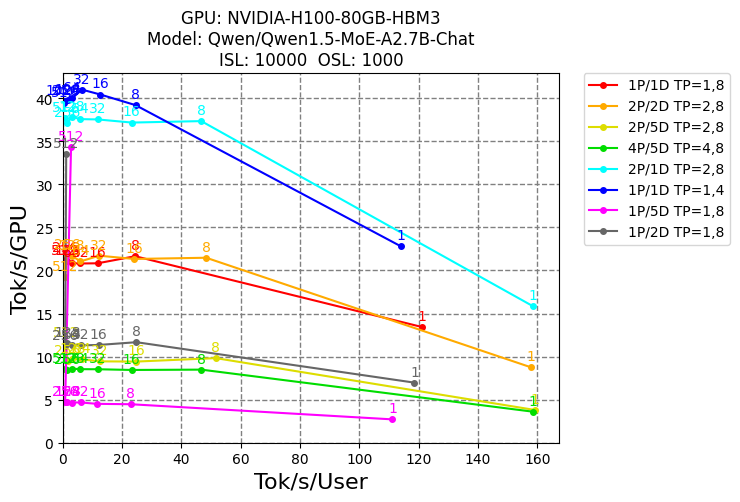

In [99]:
# Plot performance results
import matplotlib
import matplotlib.pyplot as plt

colors = ['#FF0000', '#FFAA00', '#DDDD00', '#00DD00', '#00FFFF', '#0000FF',
          '#FF00FF', '#666666', '#000000']

# Sweep through configurations
for ii, conf in enumerate(configs):
    # Make a DataFrame for specific configuration
    conf_df = runs_selected[
        (runs_selected['P_TP'] == conf[0]) &
        (runs_selected['P_Replicas'] == conf[1]) &
        (runs_selected['D_TP'] == conf[2]) &
        (runs_selected['D_Replicas'] == conf[3])
    ].sort_values(by='Concurrency')
    display(conf_df)

    # Plot throughputs for configuration
    plt.plot(conf_df.Thpt_per_User, conf_df.Thpt_per_GPU,
             label=f'{conf[0]}P/{conf[3]}D TP={conf[0]},{conf[2]}',
             marker='o', markersize=4,
             color=colors[ii%len(colors)]
            )
    for jj, val in enumerate(conf_df.Concurrency):
        plt.text(list(conf_df.Thpt_per_User)[jj],
                 list(conf_df.Thpt_per_GPU)[jj]+0.8,
                 str(val), ha='center', color=colors[ii%len(colors)])

plt.title(f'GPU: {gpu}\nModel: {model}\nISL: {isl}  OSL: {osl}')
plt.xlabel('Tok/s/User', fontsize='16')
plt.ylabel('Tok/s/GPU', fontsize='16')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, linewidth=1, ls='--', color='gray')
plt.axis([0, None, 0, None])
plt.show()
